In [1]:
# Пути к файлам
labels_csv='../input/dog-breed-identification/labels.csv'
sample_submission_csv='../input/dog-breed-identification/sample_submission.csv'

# Пути до картинок
jpg_train='../input/dog-breed-identification/train/{}.jpg'  
jpg_test='../input/dog-breed-identification/test/{}.jpg'

# Настройки нейросети
img_size = 224 # Размер изображения
num_class = 120 # Кол-во классов
batch_size = 32
Epochs = 64

# Настройки нейросети
#img_size = 224 # Размер изображения

## Загружаем библиотеки

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from keras import regularizers
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import categorical_accuracy, categorical_crossentropy
import os
import cv2, random, time, shutil, csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import time
from keras.utils import to_categorical
import gc
import tqdm

In [3]:
def gen_graph(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('crossentropy ' + title)
    plt.ylabel('crossentropy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('categorical_accuracy ' + title)
    plt.ylabel('categorical_accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Считываем изображения и переводим в массив

In [4]:
# set image size here
data_dir = '../input/dog-breed-identification'
data_df = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
class_names = sorted(data_df['breed'].unique())
print(f"No. of classes read - {len(class_names)}")
time.sleep(1)

images_list = sorted(os.listdir(os.path.join(data_dir, 'train')))
X = []
Y = []
i = 0
for image in tqdm.tqdm(images_list):
    cls_name = data_df[data_df['id'] == image[:-4]].iloc[0,1]
    cls_index = int(class_names.index(cls_name)) 

    # Reading RGB Images
    image_path = os.path.join(data_dir, 'train',image)
    orig_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    res_image = cv2.resize(orig_image,(img_size, img_size))
    X.append(res_image)
    Y.append(cls_index)
    i+=1

No. of classes read - 120


100%|██████████| 10222/10222 [03:04<00:00, 55.29it/s]


In [5]:
# Converting to arrays
print(len(X), len(Y))
Xarr = np.array(X)
Yarr = np.array(Y).reshape(-1,1)

# converting labels to one hot
Yarr_hot = to_categorical(Y)

del(X)
print(Xarr.shape, Yarr.shape, Yarr_hot.shape)
gc.collect()

10222 10222
(10222, 224, 224, 3) (10222, 1) (10222, 120)


20

## Формируем датасет для обучения

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(Xarr, Yarr_hot, shuffle=True,  test_size=0.2)

In [7]:
del Xarr, Yarr_hot, Yarr

In [8]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape,Y_valid.shape)

(8177, 224, 224, 3) (8177, 120)
(2045, 224, 224, 3) (2045, 120)


## Создаем генератор изображений

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=35, #поворот
                            horizontal_flip=True,
                            vertical_flip=True,
                            shear_range=15
                                )

test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(X_train)
test_datagen.fit(X_valid)

# Создаем генераторы 
train_generator =train_datagen.flow(X_train, Y_train, 
                               batch_size=batch_size)

test_generator =test_datagen.flow(X_valid, Y_valid,
                              batch_size=batch_size)



In [10]:
x,y = next(train_generator)

print(type(x))
print(train_generator.n)
print(x.shape)
print(y.shape)
del x,y

<class 'numpy.ndarray'>
8177
(32, 224, 224, 3)
(32, 120)


## Создаем модель нейросети

In [11]:

# Создаем последовательную модель
model = Sequential()

# сверточный слой
model.add(Conv2D(64, (3, 3), padding='same',input_shape=(img_size, img_size, 3), activation='relu'))
# сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='same'))
# Слой регуляризации Dropout
model.add(Dropout(0.20))


# сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# сверточный слой
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='same'))
# Слой регуляризации Dropout
model.add(Dropout(0.20))


# сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# сверточный слой
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# сверточный слой
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='same'))
# Слой регуляризации Dropout
model.add(Dropout(0.20))

# сверточный слой
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# сверточный слой
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# сверточный слой
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# Четвертый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='same'))
# Слой регуляризации Dropout
model.add(Dropout(0.20))

# сверточный слой
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# сверточный слой
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# сверточный слой
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# Четвертый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='same'))
# Слой регуляризации Dropout
model.add(Dropout(0.20))





# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.30))
model.add(Dense(1024, activation='relu'))
# Слой регуляризации Dropout
model.add(Dropout(0.30))


# Выходной полносвязный слой
model.add(Dense(num_class, activation='softmax'))

In [12]:
model.compile(optimizer='adam',
          loss='categorical_crossentropy', 
           metrics=['categorical_accuracy'])

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0

Функция для остановки сети и сохранения лучших результатов

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

earlystop=EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

checkpoint_callback = ModelCheckpoint('model_best.hdf5',
                                      monitor='val_categorical_accuracy', 
                                      #save_best_only=True
                                     mode='auto')

## Обучаем нейросеть

In [15]:
history = model.fit(
    train_generator,
    callbacks=[earlystop, checkpoint_callback],
    epochs=Epochs,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size
    )

Epoch 1/64
255/255 [==============================] - 116s 457ms/step - loss: 4.9039 - categorical_accuracy: 0.0120 - val_loss: 4.7861 - val_categorical_accuracy: 0.0094
Epoch 2/64
255/255 [==============================] - 115s 452ms/step - loss: 4.7809 - categorical_accuracy: 0.0133 - val_loss: 4.7868 - val_categorical_accuracy: 0.0094
Epoch 3/64
255/255 [==============================] - 116s 453ms/step - loss: 4.7789 - categorical_accuracy: 0.0130 - val_loss: 4.7884 - val_categorical_accuracy: 0.0094
Epoch 4/64
255/255 [==============================] - 116s 453ms/step - loss: 4.7787 - categorical_accuracy: 0.0124 - val_loss: 4.7908 - val_categorical_accuracy: 0.0084
Epoch 5/64
255/255 [==============================] - 116s 456ms/step - loss: 4.7778 - categorical_accuracy: 0.0131 - val_loss: 4.7900 - val_categorical_accuracy: 0.0094
Epoch 6/64
255/255 [==============================] - 116s 456ms/step - loss: 4.7771 - categorical_accuracy: 0.0131 - val_loss: 4.7907 - val_categoric

## Построим графики процесса обучения

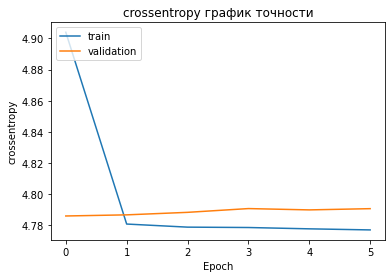

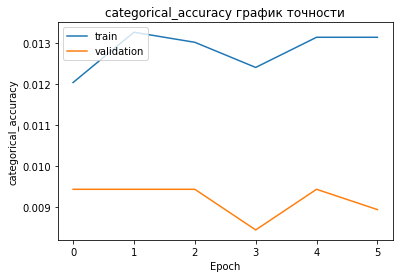

In [16]:
#График точности на валидационной и обучающей выборке
gen_graph(history,
          "график точности")

## Выберем лучшую модель и получим результаты для тестов

In [17]:
del X_train, X_valid, Y_train, Y_valid

In [18]:
images_list = sorted(os.listdir(os.path.join(data_dir, 'test')))
x_test=[]
for image in tqdm.tqdm(images_list):    
    image_path = os.path.join(data_dir, 'test',image)
    orig_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    res_image = cv2.resize(orig_image,(img_size, img_size))
    x_test.append(res_image)
x_test=np.array(x_test)

100%|██████████| 10357/10357 [03:20<00:00, 51.61it/s]


In [19]:
x_test.shape

(10357, 224, 224, 3)

In [20]:
from tensorflow.keras.models import load_model
model=load_model("model_best.hdf5")

In [21]:
preds = model.predict(x_test)

In [22]:
df_train = pd.read_csv(labels_csv)
df_test = pd.read_csv(sample_submission_csv)
labels = df_train['breed']
one_hot = pd.get_dummies(labels, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [23]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
sub.insert(0, 'id', df_test['id'])
sub.head(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008211,0.019793,0.010139,0.017985,0.006580,0.005352,0.014269,0.021809,0.006224,...,0.005174,0.005273,0.003654,0.004628,0.007491,0.006211,0.005169,0.010497,0.008139,0.006915
1,00102ee9d8eb90812350685311fe5890,0.007984,0.022539,0.010296,0.020322,0.006006,0.004748,0.015104,0.025305,0.005636,...,0.004533,0.004771,0.002986,0.004023,0.007110,0.005630,0.004531,0.010625,0.007738,0.006341
2,0012a730dfa437f5f3613fb75efcd4ce,0.008340,0.017777,0.009967,0.016270,0.006955,0.005804,0.013584,0.019273,0.006642,...,0.005661,0.005677,0.004216,0.005114,0.007708,0.006628,0.005680,0.010367,0.008327,0.007317
3,001510bc8570bbeee98c8d80c8a95ec1,0.008048,0.021756,0.010277,0.019649,0.006143,0.004886,0.014933,0.024201,0.005807,...,0.004691,0.004959,0.003154,0.004181,0.007237,0.005808,0.004708,0.010597,0.007832,0.006532
4,001a5f3114548acdefa3d4da05474c2e,0.008207,0.019965,0.010170,0.018131,0.006505,0.005288,0.014348,0.021892,0.006196,...,0.005112,0.005279,0.003602,0.004590,0.007450,0.006176,0.005141,0.010518,0.008082,0.006881


In [24]:
sub.to_csv("output_rmsprop_aug.csv", index=False)